# Домашнее задание №1

In [ ]:
!pip install wandb

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import gc
import wandb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
seed = 79
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
wandb.login()

wandb: Currently logged in as: ybojmatovv (yusufs_team). Use `wandb login --relogin` to force relogin


True

## **Данные**

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
batch_size = 256

In [ ]:
def data_loader(data_dir, batch_size, random_seed=seed,
                valid_size=0.1, shuffle=True, test=False):

    normalize = transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )

    # Определение преобразований
    transform = transforms.Compose([
            transforms.Resize((224,224)),  # Изменение размера изображения
            transforms.ToTensor(),          # Преобразование в тензор
            normalize,                      # Нормализация
    ])

    if test:
        dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
        data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return data_loader

    # Загрузка набора данных
    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    valid_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)
    return (train_loader, valid_loader)


# Набор данных CIFAR10
train_loader, valid_loader = data_loader(data_dir='./data', batch_size=batch_size)

test_loader = data_loader(data_dir='./data', batch_size=batch_size, test=True)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Модель (деофлтная, но со специями)

In [ ]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 8
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(8),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 128, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Лупа обучения

In [ ]:
num_classes = 10
num_epochs = 10
learning_rate = 0.013
weight_decay = 0.001
momentum = 0.9

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)

In [ ]:
wandb.init(project="resnet")
wandb.config = {"learning_rate": learning_rate,
                "weight_decay": weight_decay,
                "momentum": momentum,
                "epochs": num_epochs,
                "batch_size": batch_size,
                "classes": num_classes,
                "dataset": "CIFAR10",
                "architecture": "ResNet"}

wandb.watch(model, criterion, log="all", log_freq=10)

[]

In [ ]:
%%time

for epoch in range(num_epochs):
    t0 = time.time()
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}, Time: {:.2f}s'.format(epoch+1, num_epochs, loss.item(), time.time() - t0))

    # Validation
    list_labels = np.array([])
    list_preds = np.array([])

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            list_labels = np.append(list_labels, labels.cpu().numpy())
            list_preds = np.append(list_preds, predicted.cpu().numpy())
            del images, labels, outputs

        list_labels = list_labels.astype(int)
        list_preds = list_preds.astype(int)

        wandb.log({"epoch": epoch + 1,
                   "loss": loss.item(),
                   "accuracy ": accuracy_score(list_labels, list_preds),
                   "precision":  precision_score(list_labels, list_preds, average='weighted'),
                   "recall": recall_score(list_labels, list_preds, average='weighted'),
                   "f1": f1_score(list_labels, list_preds, average='weighted')})

Epoch [1/10], Loss: 1.0750, Time: 212.88s
Epoch [2/10], Loss: 0.8508, Time: 202.48s
Epoch [3/10], Loss: 0.5206, Time: 201.31s
Epoch [4/10], Loss: 0.6499, Time: 201.44s
Epoch [5/10], Loss: 0.6612, Time: 201.55s
Epoch [6/10], Loss: 0.4851, Time: 201.59s
Epoch [7/10], Loss: 0.3260, Time: 201.02s
Epoch [8/10], Loss: 0.3630, Time: 201.75s
Epoch [9/10], Loss: 0.3121, Time: 210.88s
Epoch [10/10], Loss: 0.2934, Time: 202.36s
CPU times: user 31min 9s, sys: 4min 24s, total: 35min 33s
Wall time: 36min 1s


## Результаты

In [ ]:
list_labels = []
list_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        list_labels.extend(labels.cpu().numpy())
        list_preds.extend(predicted.cpu().numpy())
        del images, labels, outputs

In [ ]:
print(classification_report(list_labels, list_preds))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1000
           1       0.92      0.90      0.91      1000
           2       0.76      0.74      0.75      1000
           3       0.71      0.63      0.67      1000
           4       0.83      0.76      0.80      1000
           5       0.74      0.77      0.76      1000
           6       0.85      0.84      0.85      1000
           7       0.84      0.88      0.86      1000
           8       0.88      0.90      0.89      1000
           9       0.88      0.87      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:

confusion = confusion_matrix(list_labels, list_preds)
total_samples_per_class = confusion.sum(axis=1)
df_metrics = pd.DataFrame(data={
    "Accuracy": confusion.diagonal() / total_samples_per_class,
    "Precision": precision_score(list_labels,  list_preds, average = None),
    "Recall": recall_score(list_labels,  list_preds, average = None),
    "F1 score": f1_score(list_labels,  list_preds, average = None)
})
df_metrics

,Accuracy,Precision,Recall,F1 score
0,0.897,0.782723,0.897,0.835974
1,0.900,0.915565,0.900,0.907716
2,0.743,0.762834,0.743,0.752786
3,0.631,0.711387,0.631,0.668786
4,0.762,0.833698,0.762,0.796238
5,0.771,0.740634,0.771,0.755512
6,0.844,0.846540,0.844,0.845268
7,0.877,0.839234,0.877,0.857702
8,0.897,0.881139,0.897,0.888999
9,0.872,0.876382,0.872,0.874185


In [ ]:
print("Accuracy", accuracy_score(list_labels,  list_preds))
print("Precision", precision_score(list_labels,  list_preds, average='weighted'))
print("Recall", recall_score(list_labels,  list_preds, average='weighted'))
print("F1 score", f1_score(list_labels,  list_preds, average='weighted'))

Accuracy 0.8194
Precision 0.8190134987310945
Recall 0.8194
F1 score 0.8183166476110744


<Axes: >

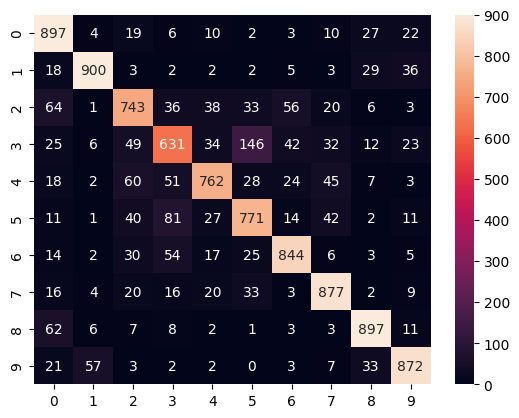

In [ ]:
sns.heatmap(confusion, annot=True, fmt='g')

# Один из примеров (с ошибками, чтобы понимать error cases)

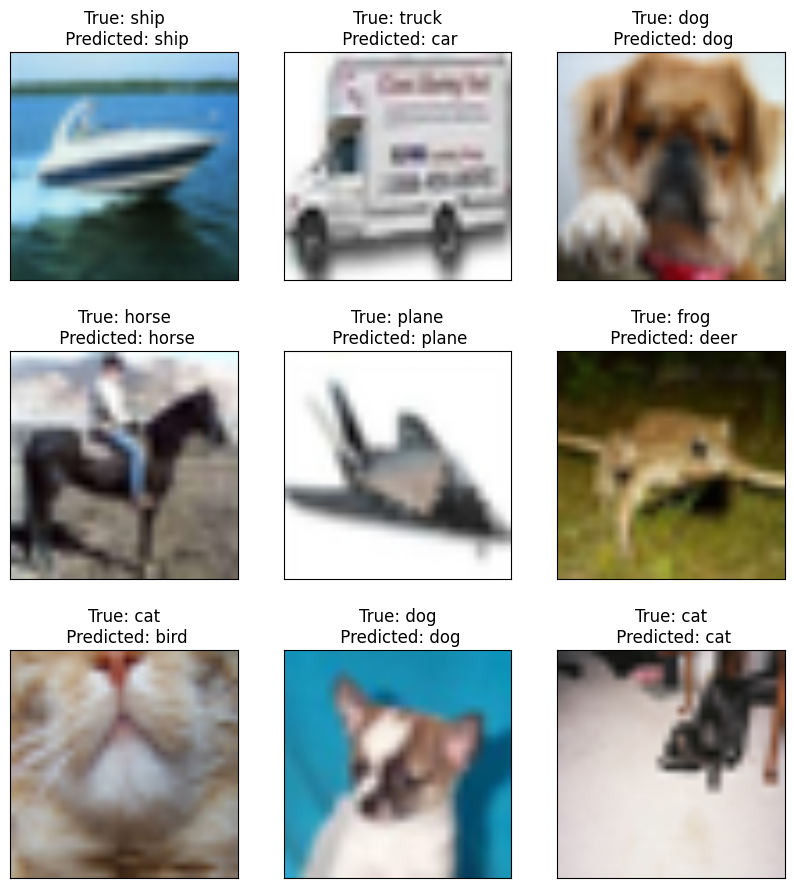

In [ ]:
fig = plt.figure(figsize=(10, 11))
for i in range(9):
    images, labels = next(iter(test_loader))
    with torch.no_grad():
        #images1 = images.to(device)
        #labels1 = labels.to(device)
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        single_image = np.transpose(np.array(images[0].to('cpu')), (1,2,0))
        plt.imshow(single_image/2 + 0.5)
        ax.set_title(f"True: {classes[labels[0].item()]}\n Predicted: {classes[predicted[0].item()]}")
        del images, labels, outputs

plt.show()

In [ ]:
wandb.finish()

accuracy,▁▄▆▆▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▆▆▇█████
loss,█▆▃▄▄▃▁▂▁▁
precision,▁▅▆▆▇█████
recall,▁▄▆▆▇█████
accuracy,0.8184
epoch,10
f1,0.81739
loss,0.29335
precision,0.81874
